In [1]:
# Imports and basic setup
### UNCOMMENT THE CORRECT ONE
# If you are using Jupyter Lab
# %matplotlib widget

# If you are using Jupyter Notebook
%matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 40})
import pandas as pd
import numpy as np
import scipy
import scipy.signal

## Ex 11.1: Extraction of Q-, R-, and S-peaks

To perform waveform analysis on individual heartbeats in an ECG signal, we need to find all relevant peaks within each repetition of the signal.

a) Load the example ecg file (`103.csv`) from the data folder using pandas. The signal is sampled at 360 Hz. Optionally apply a band-pass filter to see its effect.

b) Load the file `103_all.csv`. It contains the position of all R-peaks in the signal.

c) Extract all QRST complexes from the signal by considering a region spanning from 50 ms before until 250 ms after the R-peak.

d) Create a function to find the Q-peak by looking for a minimum left of the R-peaks within a reasonable interval.

e) Create a function to find the S-peak by looking for a minimum right of the R-peaks within a reasonable interval.

f) Add the position of the Q- and the S-peak as new columns to the DataFrame loaded in step b)


In [8]:
# Load the data and store it in a pd.Series called signal.
# Ensure that the index is in seconds
SUBJECT = 103
sampling_rate = 360  # hz

### BEGIN SOLUTION
signal = pd.read_csv('./data/{}.csv'.format(SUBJECT), index_col=0)['ecg']
signal.index /= sampling_rate
### END SOLUTION

# Optionally apply a bandpass filter to the signal (3-50 Hz passband)
# Test all computations in this exercise  with and without the filter
### BEGIN SOLUTION
bandpass_filter = scipy.signal.butter(5, (3, 50), btype='bandpass', fs=sampling_rate)
signal = pd.Series(scipy.signal.filtfilt(*bandpass_filter, signal))
signal.index /= sampling_rate
### END SOLUTION



In [10]:
# Load the labeled R-peaks an store them in pd.DataFrame called `peaks`
### BEGIN SOLUTION
peaks = pd.read_csv('./data/{}_all.csv'.format(SUBJECT), index_col=0)
peaks.head()
### END SOLUTION

,R
0,265
1,575
2,876
3,1180
4,1482


<IPython.core.display.Javascript object>


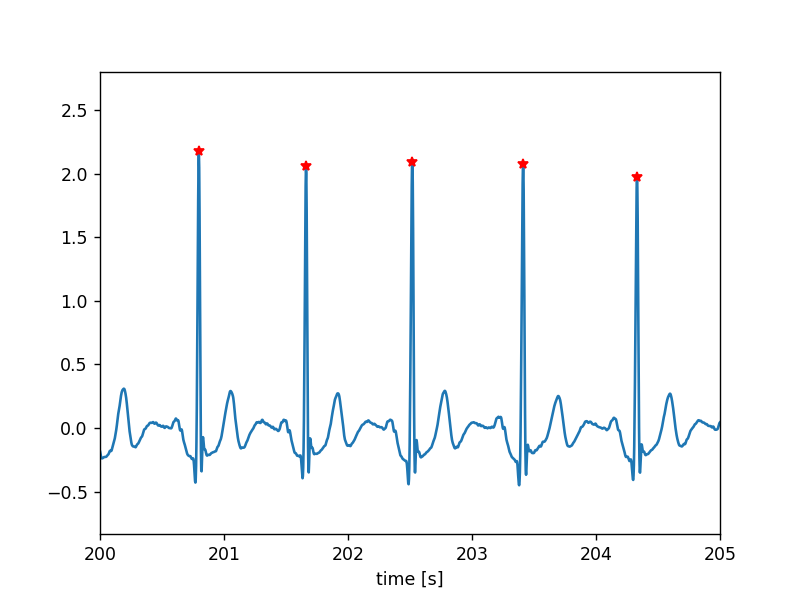

In [11]:
plt.figure()
signal.plot()

# r peaks
pos = peaks['R']/sampling_rate
plt.plot(pos, signal.loc[pos], 'r*')

plt.xlabel('time [s]')
plt.xlim(200, 205);

In [12]:
def extract_qrst_complexes(signal, r_peaks, sampling_rate=360):
    """Extract all qrst complexes from a continous signal.
    
    Cuts out a region of -50ms to 250ms around each provided R-peak
    
    Args:
        signal: np.array of ecg signal
        r_peaks: list of indices indicating the postion of R-peaks in the signal
        sampling_rate: Ssampling rate of the recording
        
    Returns:
        qrst: np.array with fixed number of culumns and one qrst complex per row
    """
    signal = np.array(signal)
    ### BEGIN SOLUTION
    start = r_peaks - int(50 / 1000 * sampling_rate)
    end = r_peaks + int(250 / 1000 * sampling_rate)

    qrst = []
    for s, e in zip(start, end):
        qrst.append(signal[s:e])
    qrst = np.array(qrst)
    ### END SOLUTION
    return qrst

In [13]:
qrst_complexes = extract_qrst_complexes(signal, r_peaks=peaks['R'])

In [14]:
def find_q_peak(qrst, sampling_rate=360):
    """Find the Q peak in an array of qrst complexes extracted before.
    
    The Q peak is the first valley to the left of the R-Peak
    
    Returns:
        The relative distance from the R-Peak in samples
    """
    ### BEGIN SOLUTION
    r_peak_pos = int(50/1000 * sampling_rate)
    
    index_q = np.argmin(qrst[:, :r_peak_pos], axis=-1)
    index_q = r_peak_pos - index_q
    ### END SOLUTION
    return index_q

def find_s_peak(qrst, sampling_rate=360):
    """Find the S peak in an array of qrst complexes extracted before.
    
    The S peak is the first valley to the right of the R-Peak
    
    Returns:
        The relative distance from the R-Peak in samples
    """
    ### BEGIN SOLUTION
    r_peak_pos = int(50/1000 * sampling_rate)
    # Search 80ms to the right of the r_peak
    search_index = int(80/1000 * sampling_rate)
    
    index_s = np.argmin(qrst[:, r_peak_pos: r_peak_pos + search_index], axis=-1)
    index_s = index_s
    ### END SOLUTION
    return index_s

In [15]:
peaks['Q'] = peaks['R'] - find_q_peak(qrst_complexes)
peaks['S'] = peaks['R'] + find_s_peak(qrst_complexes)
peaks.head(5)

,R,Q,S
0,265,254,273
1,575,565,583
2,876,866,884
3,1180,1170,1188
4,1482,1472,1490


<IPython.core.display.Javascript object>


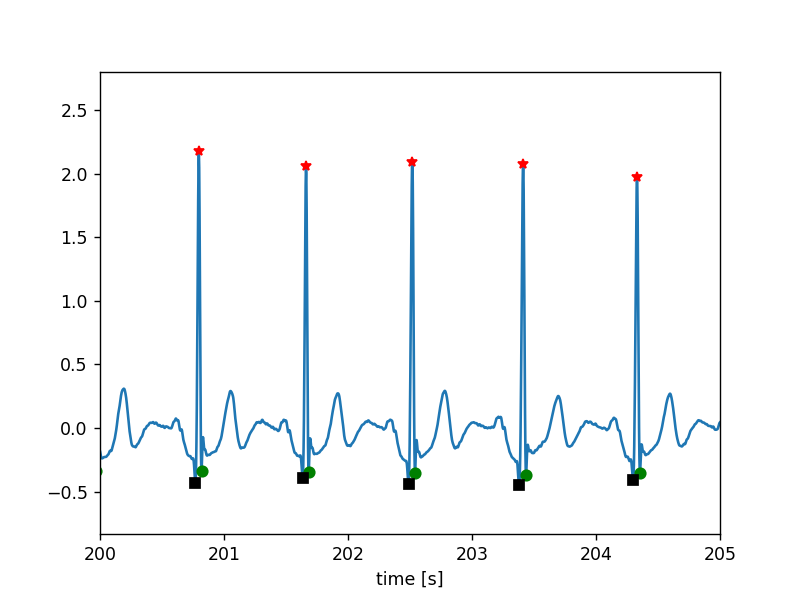

In [16]:
plt.figure()
plt.plot(signal)

peak_pos = peaks[['Q', 'R', 'S']] / sampling_rate
plt.plot(peak_pos['R'], signal.loc[peak_pos['R']], 'r*')
plt.plot(peak_pos['S'], signal.loc[peak_pos['S']], 'go')
plt.plot(peak_pos['Q'], signal.loc[peak_pos['Q']], 'ks')

plt.xlabel('time [s]')
plt.xlim(200, 205);

## Ex. 11.2: ECG feature

To describe each ectracted QRST complexes we can calculate a set of features on each complex.
These features can later be used in a ML classification.

a) Implement the following features and add each of them as a new column to the `peaks` array:

1. Compute the QRS widths as the difference between the S-peaks and the Q-peaks

2. Compute the amplitude of the QR difference

3. Compute the amplitude of the RS difference

4. Compute the area below the QRST curve as follows: 

- Subtract the mean of each QRST complex from each complex. 
- take the absolut of all values 
- Compute the area of the resulting curve by summing up all the elements. 

5. Compute the normalized scalar product of a QRS complex and the template of a normal QRS complex with the following formula: 
$$
c=\frac{\sum_{n = 1}^{N} [x(n) - min(x)] [y (n) - min(y)]}{\sqrt{\sum_{n=1}^{N}[x(n) - min(x)]^2 \sum_{n=1}^{N}[y(n) - min(y)]^2 }}
$$
$x(n) = $ template (first QRS complex of the ECG signal),
$y(n) = $ the QRS complex of interest,
$N = $ amount of samples the heartbeat contains,

b) Plot the results of all features and visually inspect potential outliers.

In [17]:
# Implement the following feature and add each of them as a new column to the `peaks` array

# QRS-width
# Calculate the distance between the S- and the Q-"valley" in seconds
### BEGIN SOLUTION
peaks['QRS_Width'] = (peaks['S'] - peaks['Q']) / sampling_rate
### END SOLUTION

# QR Amplitude difference
# Calculate the amplitude difference between the R-peak and the Q-valey
### BEGIN SOLUTION
peaks['QR_amplitude'] = signal.values[peaks['R'].values] - signal.values[peaks['Q'].values]
### END SOLUTION

# RS Amplitude difference
# Calculate the amplitude difference between the R-peak and the S-valey
### BEGIN SOLTUION
peaks['RS_amplitude'] = signal.values[peaks['R'].values] - signal.values[peaks['S'].values]
### END SOLUTION

# QRST Area
# Calculate the area under each QRST complex after substracting the mean value of each complex to
# normalize the baseline
### BEGIN SOLUTION
peaks['QRST_area'] = np.sum(np.abs((qrst_complexes.T - np.mean(qrst_complexes, axis=-1)).T), axis=-1)
### END SOLUTION

# Template Match
# We assume the first peak in the series is a normal QRST complex
# Substract the baseline (minimum) from every qrst complex and then calculate the normalised dot-product (a*b/(|a||b|))
### BEGIN SOLUTION
baseline_correctes_qrst = (qrst_complexes.T - np.min(qrst_complexes, axis=-1)).T
baseline_correctes_norm = np.linalg.norm(baseline_correctes_qrst, axis=-1)
distance = np.dot(baseline_correctes_qrst, baseline_correctes_qrst[0])
distance /= baseline_correctes_norm * baseline_correctes_norm[0]
peaks['Template'] = distance
### END SOLUTION

<IPython.core.display.Javascript object>


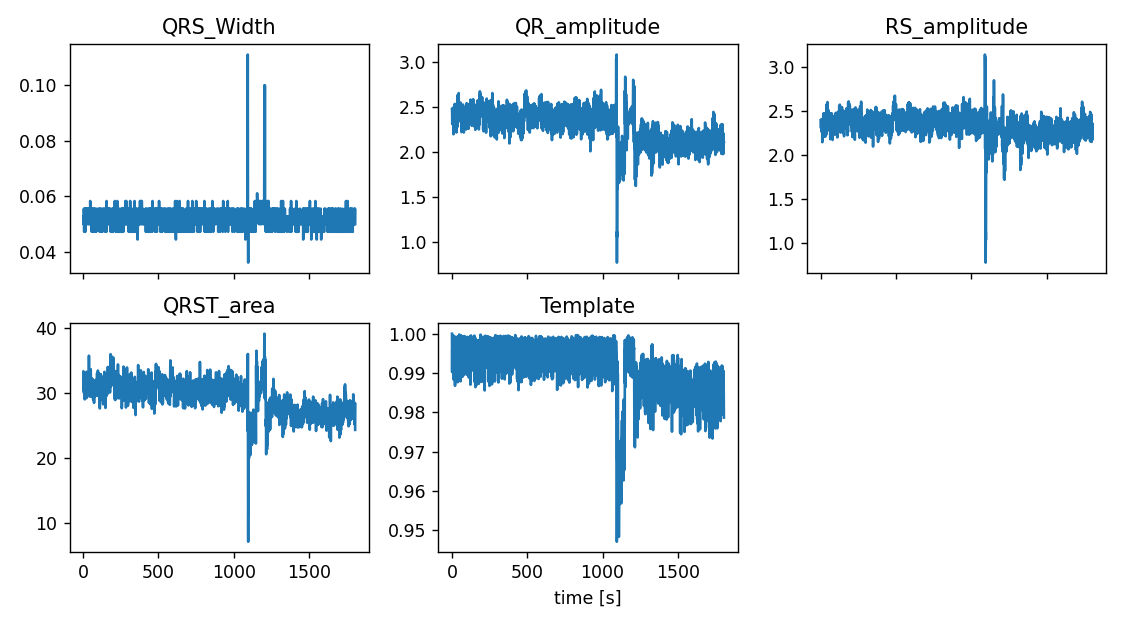

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(9, 5))

for ax, feature in zip(axs.flatten(), ['QRS_Width', 'QR_amplitude', 'RS_amplitude', 'QRST_area', 'Template']):
    ax.plot(peaks['R']/sampling_rate, peaks[feature])
    ax.set_title(feature)

axs[1, 1].set_xlabel('time [s]')
plt.tight_layout()
axs[1, -1].remove()

## Ex. 11.3: Critical analysis of the pipeline

a) Look through the results and the plotted ECG signal. What are potential issues that could have effected our feature calculation?

b) How could we solve these issues?

### Solution:

1. Baseline drift in the signal might affect integral -> high-pass filter the signal
2. Noise might affect the detection of peaks -> low-pass filter the signal
3. The template is specific to a single person -> No real solution. Finding a general template is complicated, as the signal amplitude will change based on the recording device and electrode setup

Note, that the band-pass filter we used did not change the parameters in a drastic way, but in a general case this is still a good idea.